# TPUs in Colab&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>
In this example, we'll work through training a model to classify images of
flowers on Google's lightning-fast Cloud TPUs. Our model will take as input a photo of a flower and return whether it is a daisy, dandelion, rose, sunflower, or tulip.

We use the Keras framework, new to TPUs in TF 2.1.0. Adapted from [this notebook](https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/07_Keras_Flowers_TPU_xception_fine_tuned_best.ipynb) by [Martin Gorner](https://twitter.com/martin_gorner).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### License

Copyright 2019-2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose.


## Enabling and testing the TPU

First, you'll need to enable TPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select TPU from the Hardware Accelerator drop-down

Next, we'll check that we can connect to the TPU:

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.6.0
Running on TPU  ['10.90.250.18:8470']
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.90.250.18:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.90.250.18:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
import re
import numpy as np
from matplotlib import pyplot as plt

## Import model from GitHub repo

In [ ]:
TOKEN=""
!git clone %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


## Input data

Our input data is stored on Google Cloud Storage. To more fully use the parallelism TPUs offer us, and to avoid bottlenecking on data transfer, we've stored our input data in TFRecord files, 230 images per file.

Below, we make heavy use of `tf.data.experimental.AUTOTUNE` to optimize different parts of input loading.

All of these techniques are a bit overkill for our (small) dataset, but demonstrate best practices for using TPUs.


### Extract `.zip` and generate filenames

In [ ]:
import zipfile
from tqdm import tqdm

with zipfile.ZipFile('/content/drive/MyDrive/Computer Vision research/archive.zip') as zf:
    for member in tqdm(zf.infolist(), desc='Extracting '):
        if member.filename[-4:]=='jpeg':
            try:
                zf.extract(member, '/content/')
            except zipfile.error as e:
                pass
        else:
            continue

Extracting : 100%|██████████| 84484/84484 [01:27<00:00, 961.87it/s] 


In [ ]:
from random import shuffle
import glob
import sys
import cv2
#import skimage.io as io

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def load_image(addr):
    # read an image and resize to (224, 224)
    # cv2 load images as BGR, convert it to RGB
    img = cv2.imread(addr)
    if img is None:
        return None
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
 
def createDataRecord(out_filename, addrs, labels):
    # open the TFRecords file
    writer = tf.io.TFRecordWriter(out_filename)
    for i in range(len(addrs)):
        # print how many images are saved every 1000 images
        if not i % 10000:
            print('Train data: {}/{}'.format(i, len(addrs)))
            sys.stdout.flush()
        # Load the image
        img = load_image(addrs[i])

        label = labels[i]

        if img is None:
            continue

        # Create a feature
        feature = {
            'image_raw': _bytes_feature(img.tobytes()),
            'label': _int64_feature(label)
        }
        # Create an example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        
        # Serialize to string and write on the file
        writer.write(example.SerializeToString())
        
    writer.close()
    sys.stdout.flush()

data_path = '/content/OCT2017 /train/*/*.jpeg'
# read addresses and labels from the 'train' folder
addrs = glob.glob(data_path)
label2idx = {'CNV':0, 'DME':1, 'DRUSEN':2, 'NORMAL':3}
labels = [0 if "CNV" in addr.split('/') else (1 if "DME" in addr.split('/') else (2 if "DRUSEN" in addr.split('/') else (3 if "NORMAL" in addr.split('/') else None))) for addr in addrs]

# to shuffle data
c = list(zip(addrs, labels))
shuffle(c)
addrs, labels = zip(*c)
    
# Divide the data into 70% train, 20% validation, and 10% test
train_addrs = addrs[0:int(0.7*len(addrs))]
train_labels = labels[0:int(0.7*len(labels))]
val_addrs = addrs[int(0.7*len(addrs)):int(0.9*len(addrs))]
val_labels = labels[int(0.7*len(addrs)):int(0.9*len(addrs))]
test_addrs = addrs[int(0.9*len(addrs)):]
test_labels = labels[int(0.9*len(labels)):]

# Save results
createDataRecord('/content/train.tfrecords', train_addrs, train_labels)
createDataRecord('/content/val.tfrecords', val_addrs, val_labels)
createDataRecord('/content/test.tfrecords', test_addrs, test_labels)

Train data: 0/62613
Train data: 10000/62613
Train data: 20000/62613
Train data: 30000/62613
Train data: 40000/62613
Train data: 50000/62613
Train data: 60000/62613
Train data: 0/16696
Train data: 10000/16696
Train data: 0/4175


### Upload to Google Cloud Storage

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!curl https://sdk.cloud.google.com | bash

In [ ]:
!gcloud init

In [ ]:
!gsutil cp /content/train.tfrecords gs://deep_vit_macula/

Copying file:///content/train.tfrecords [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

|
Operation completed over 1 objects/8.8 GiB.                                      


In [ ]:
!gsutil cp /content/val.tfrecords gs://deep_vit_macula/

Copying file:///content/val.tfrecords [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\
Operation completed over 1 objects/2.3 GiB.                                      


In [ ]:
!gsutil cp /content/test.tfrecords gs://deep_vit_macula/

Copying file:///content/test.tfrecords [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\
Operation completed over 1 objects/599.6 MiB.                                    


### Create datasets

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
seed = 123
IMAGE_SIZE = [224,224]
num_classes = 4
batch_size = 16 * tpu_strategy.num_replicas_in_sync
        
def parse_tfrecord(example):
  features = {
    "image_raw": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
    "label": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
  }
  example = tf.io.parse_single_example(example, features)
  decoded = tf.image.decode_jpeg(example['image_raw'], channels=3)
  normalized = tf.cast(decoded, tf.float32) / 255.0 # convert each 0-255 value to floats in [0, 1] range
  image_tensor = tf.reshape(normalized, [*IMAGE_SIZE, 3])
  one_hot_class = tf.one_hot(example['label'], num_classes)
  return image_tensor, one_hot_class

def load_dataset(filenames):
  # Read from TFRecords. For optimal performance, we interleave reads from multiple files.
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO)

def get_training_dataset(filenames):
  dataset = load_dataset(filenames)

  # Create some additional training images by randomly flipping and
  # increasing/decreasing the saturation of images in the training set. 
  def data_augment(image, one_hot_class):
    modified = tf.image.random_flip_left_right(image)
    return modified, one_hot_class
  augmented = dataset.map(data_augment, num_parallel_calls=AUTO)

  # Prefetch the next batch while training (autotune prefetch buffer size).
  return augmented.repeat().shuffle(2048).batch(batch_size).prefetch(AUTO) 

# Build tf.data.Dataset from folder structure
filenames=["gs://deep_vit_macula/train.tfrecords",
           "gs://deep_vit_macula/val.tfrecords",
           "gs://deep_vit_macula/test.tfrecords"]

# TFRecordDataset
training_dataset = get_training_dataset(filenames[0])
validation_dataset = load_dataset(filenames[1]).batch(batch_size).prefetch(AUTO)

Let's take a peek at the training dataset we've created:

In [ ]:
CLASSES = ["CNV", "DME", "DRUSEN", "NORMAL"]

def display_one_flower(image, title, subplot, color):
  plt.subplot(subplot)
  plt.axis('off')
  plt.imshow(image)
  plt.title(title, fontsize=16, color=color)
  
# If model is provided, use it to generate predictions.
def display_nine_flowers(images, titles, title_colors=None):
  subplot = 331
  plt.figure(figsize=(13,13))
  for i in range(9):
    color = 'black' if title_colors is None else title_colors[i]
    display_one_flower(images[i], titles[i], 331+i, color)
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def get_dataset_iterator(dataset, n_examples):
  return dataset.unbatch().batch(n_examples).as_numpy_iterator()

training_viz_iterator = get_dataset_iterator(training_dataset, 9)

In [ ]:
# Re-run this cell to show a new batch of images
images, classes = next(training_viz_iterator)
class_idxs = np.argmax(classes, axis=-1) # transform from one-hot array to class number
labels = [CLASSES[idx] for idx in class_idxs]
display_nine_flowers(images, labels)

## Model
To get maxmimum accuracy, we leverage a pretrained image recognition model (here, [Xception](http://openaccess.thecvf.com/content_cvpr_2017/papers/Chollet_Xception_Deep_Learning_CVPR_2017_paper.pdf)). We drop the ImageNet-specific top layers (`include_top=false`), and add a max pooling and a softmax layer to predict our 5 classes.

In [ ]:
import tensorflow.keras.backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from deep_vit_macula.model.tf.ViT_model import ViT_classifier

with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  inputs = tf.keras.Input(shape=(224,224,3))
  outputs = ViT_classifier(depth=2,depth_te=4,linear_list=[64,4],preprocessing='conv',num_patches=64,patch_size=16,num_channels=3,hidden_dim=128,num_heads=16,attn_drop=.2,proj_drop=.2,linear_drop=.2)(inputs)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam',loss=tf.losses.CategoricalCrossentropy(from_logits=True,label_smoothing=.05), metrics=['acc',f1_m])
model.summary()

## Training

Calculate the number of images in each dataset. Rather than actually load the data to do so (expensive), we rely on hints in the filename. This is used to calculate the number of batches per epoch.


In [ ]:
gcs_pattern = 'gs://deep_vit_macula/*.tfrecords'
filenames = tf.io.gfile.glob(gcs_pattern)

In [ ]:
n_train = len(train_addrs)
n_valid = len(val_addrs)
train_steps = n_train // batch_size
print("TRAINING IMAGES: ", n_train, ", STEPS PER EPOCH: ", train_steps)
print("VALIDATION IMAGES: ", n_valid)

TRAINING IMAGES:  62613 , STEPS PER EPOCH:  489
VALIDATION IMAGES:  16696


Calculate and show a learning rate schedule. We start with a fairly low rate, as we're using a pre-trained model and don't want to undo all the fine work put into training it.

Learning rate per epoch:


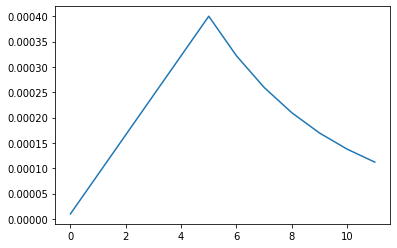

In [ ]:
EPOCHS = 12

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005 * tpu_strategy.num_replicas_in_sync
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

Actually train the model. While the first epoch will be quite a bit slower as we must XLA-compile the execution graph and load the data, later epochs should complete in ~5s.

In [ ]:
history = model.fit(training_dataset, validation_data=validation_dataset,
                    steps_per_epoch=train_steps, epochs=EPOCHS, callbacks=[lr_callback])

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

Epoch 1/12

Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.


ValueError: ignored

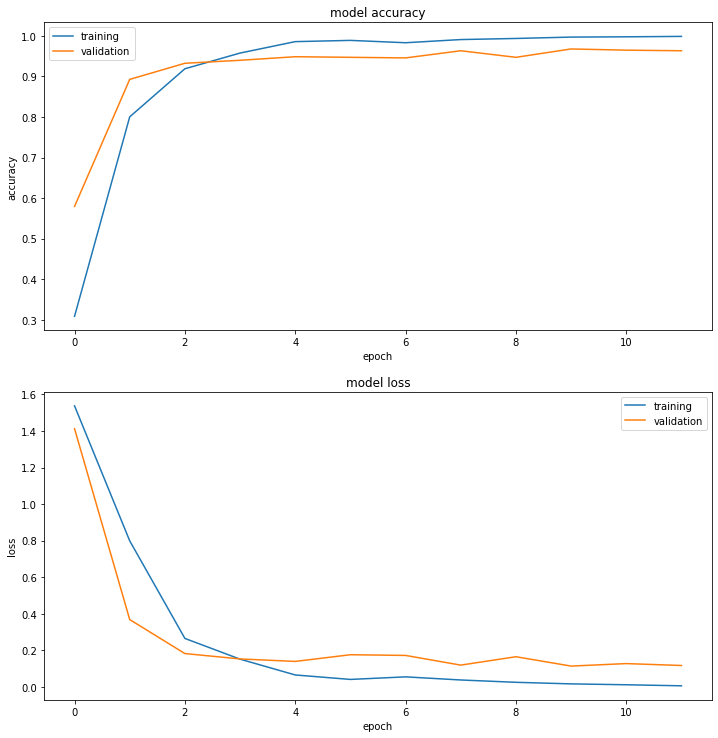

In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

Accuracy goes up and loss goes down. Looks good!

## Predictions

Let's look at some our model's predictions next to the original images. We'll show 9 images from the validation set.

In [ ]:
def flower_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
  class_idx = np.argmax(label, axis=-1)
  prediction_idx = np.argmax(prediction, axis=-1)
  if class_idx == prediction_idx:
    return f'{CLASSES[prediction_idx]} [correct]', 'black'
  else:
    return f'{CLASSES[prediction_idx]} [incorrect, should be {CLASSES[class_idx]}]', 'red'

def get_titles(images, labels, model):
  predictions = model.predict(images)
  titles, colors = [], []
  for label, prediction in zip(classes, predictions):
    title, color = flower_title(label, prediction)
    titles.append(title)
    colors.append(color)
  return titles, colors

validation_viz_iterator = get_dataset_iterator(validation_dataset, 9)

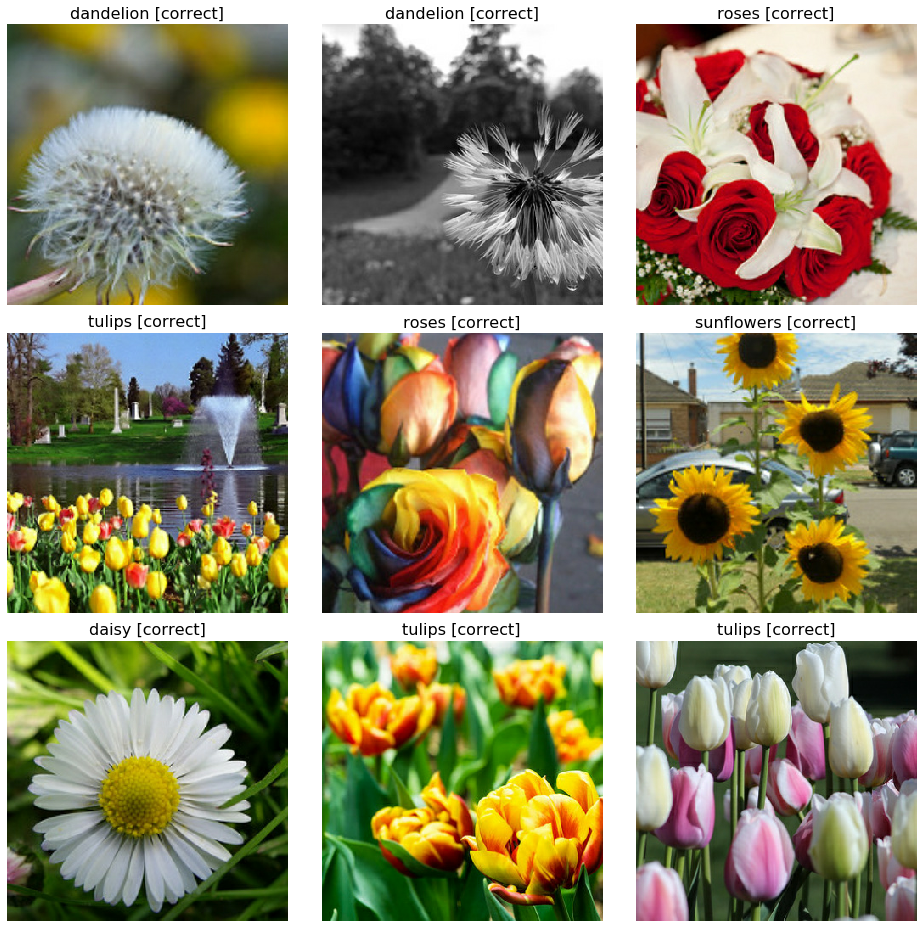

In [ ]:
# Re-run this cell to show a new batch of images
images, classes = next(validation_viz_iterator)
titles, colors = get_titles(images, classes, model)
display_nine_flowers(images, titles, colors)

## Save and re-loading our trained model

In [ ]:
# We can save our model with:
model.save('model.h5')
# and reload it with:
reloaded_model = tf.keras.models.load_model('model.h5')

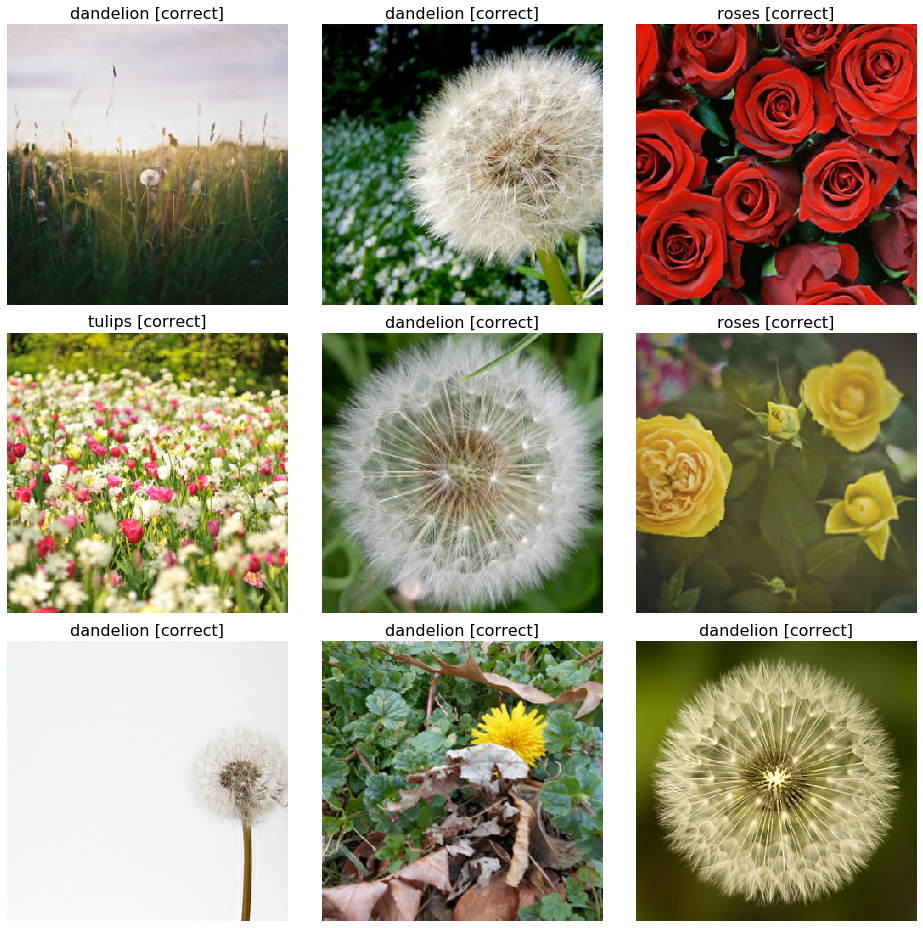

In [ ]:
# Re-run this cell to show a new batch of images
images, classes = next(validation_viz_iterator)
titles, colors = get_titles(images, classes, reloaded_model)
display_nine_flowers(images, titles, colors)

## Next steps

More TPU/Keras examples include:
- [Shakespeare in 5 minutes with Cloud TPUs and Keras](https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/shakespeare_with_tpu_and_keras.ipynb)
- [Fashion MNIST with Keras and TPUs](https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/fashion_mnist.ipynb)

We'll be sharing more examples of TPU use in Colab over time, so be sure to check back for additional example links, or [follow us on Twitter @GoogleColab](https://twitter.com/googlecolab).